# Baseline Models (No Graph Structure)

**Objective**: Classify nodes using only node features (no graph structure).

**Key principle**: Each node v evaluated at exactly t_first(v) + K to ensure K timesteps of observation.

In [1]:
import sys
from pathlib import Path

# Add project root to path
ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_observation_window_graphs
)

import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

np.random.seed(42)

## Configuration

In [2]:
from test_config import EXPERIMENT_CONFIG

CONFIG = EXPERIMENT_CONFIG
print(f"Train cohorts: t={CONFIG['train_timesteps'][0]} to {CONFIG['train_timesteps'][1]}")
print(f"Val cohorts:   t={CONFIG['val_timesteps'][0]} to {CONFIG['val_timesteps'][1]}")
print(f"Test cohorts:  t={CONFIG['test_timesteps'][0]} to {CONFIG['test_timesteps'][1]}")
print(f"Observation windows K: {CONFIG['observation_windows']}")


CONFIG['device'] = 'cpu'

Train cohorts: t=5 to 26
Val cohorts:   t=27 to 31
Test cohorts:  t=32 to 40
Observation windows K: [1, 3, 5, 7]


In [3]:
print(CONFIG['device'])

cpu


## Load Data & Create Temporal Splits

In [4]:
def remove_correlated_features(nodes_df, threshold=0.95, verbose=True):
    """
    Remove highly correlated features from nodes DataFrame.
    
    Args:
        nodes_df: DataFrame with node features
        threshold: Correlation threshold (default 0.95)
        verbose: Print removed features
    
    Returns:
        nodes_df with correlated features removed
        list of kept feature columns
    """
    # Identify feature columns (exclude address, Time step, class)
    exclude_cols = {'address', 'Time step', 'class'}
    feature_cols = [col for col in nodes_df.columns 
                    if col not in exclude_cols and 
                    pd.api.types.is_numeric_dtype(nodes_df[col])]
    
    # Compute correlation matrix on a sample (for speed)
    sample_size = min(10000, len(nodes_df))
    sample_df = nodes_df[feature_cols].sample(n=sample_size, random_state=42)
    corr_matrix = sample_df.corr().abs()
    
    # Find features to remove
    upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    to_remove = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # Remove the second feature (arbitrary choice)
                feature_to_remove = corr_matrix.columns[j]
                to_remove.add(feature_to_remove)
                if verbose:
                    print(f"Removing {feature_to_remove} (corr={corr_matrix.iloc[i, j]:.3f} with {corr_matrix.columns[i]})")
    
    # Keep features
    features_to_keep = [col for col in feature_cols if col not in to_remove]
    
    if verbose:
        print(f"\nOriginal features: {len(feature_cols)}")
        print(f"Removed features:  {len(to_remove)}")
        print(f"Kept features:     {len(features_to_keep)}")
    
    return features_to_keep

In [5]:
# Load elliptic dataset with temporal features (no leakage)
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

Loading trmporal features...
Loading node classes...
Loading edges...


In [7]:
kept_features = remove_correlated_features(nodes_df, threshold=0.95, verbose=False)
print(f"Before: {nodes_df.shape[1]}")
print(f"After: {len(kept_features)}")

Before: 119
After: 36


In [8]:
builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    feature_cols=kept_features,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../../graph_cache_reduced_features_fixed',
    use_cache=True,
    verbose=False
)

# Create temporal splits (non-overlapping cohorts)
split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True  # Only nodes with known labels
)

print(f"\nTrain: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")


Train: 104704 nodes
Val:   11230 nodes
Test:  45963 nodes


## Prepare Per-Node Observation Window Graphs

Each node v is evaluated at time t_first(v) + K.

In [9]:
graphs = prepare_observation_window_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=torch.device(CONFIG['device'])
)


PREPARING OBSERVATION WINDOW GRAPHS (PER-NODE EVALUATION)

K = 1 (Each node evaluated at t_first + 1)

TRAIN split:
  Nodes to evaluate: 104,704
  Evaluation times: t=6 to t=27
  Unique graphs needed: 22
  Total eval nodes across all graphs: 104,704

VAL split:
  Nodes to evaluate: 11,230
  Evaluation times: t=28 to t=32
  Unique graphs needed: 5
  Total eval nodes across all graphs: 11,230

TEST split:
  Nodes to evaluate: 45,963
  Evaluation times: t=33 to t=41
  Unique graphs needed: 9
  Total eval nodes across all graphs: 45,963

K = 3 (Each node evaluated at t_first + 3)

TRAIN split:
  Nodes to evaluate: 104,704
  Evaluation times: t=8 to t=29
  Unique graphs needed: 22
  Total eval nodes across all graphs: 104,704

VAL split:
  Nodes to evaluate: 11,230
  Evaluation times: t=30 to t=34
  Unique graphs needed: 5
  Total eval nodes across all graphs: 11,230

TEST split:
  Nodes to evaluate: 45,963
  Evaluation times: t=35 to t=43
  Unique graphs needed: 9
  Total eval nodes acros

## Helper Functions

In [10]:
def collect_data_from_graphs(graphs_dict):
    """Collect features and labels from all graphs in split."""
    X_list, y_list = [], []
    
    for eval_t, graph in graphs_dict.items():
        # Extract only masked nodes (those evaluated at this timestep)
        X_list.append(graph.x[graph.eval_mask].cpu().numpy())
        y_list.append(graph.y[graph.eval_mask].cpu().numpy())
    
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y


def evaluate_model(model, X, y, scaler=None):
    """Evaluate model and return metrics."""
    if scaler is not None:
        X = scaler.transform(X)
    
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(y, y_proba) if len(np.unique(y)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

## Train Baseline Models (Per-K Retraining)

**Important**: Separate model trained for each K value for proper calibration.

In [11]:
def train_baseline(model_class, model_params, K, graphs):
    """Train a baseline model for a specific K value."""
    # Collect data from all graphs in each split
    X_train, y_train = collect_data_from_graphs(graphs[K]['train']['graphs'])
    X_val, y_val = collect_data_from_graphs(graphs[K]['val']['graphs'])
    X_test, y_test = collect_data_from_graphs(graphs[K]['test']['graphs'])
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Compute class weights for imbalanced data
    class_counts = np.bincount(y_train)
    class_weight = {
        0: len(y_train) / (2 * class_counts[0]),
        1: len(y_train) / (2 * class_counts[1])
    }
    
    # Set model-specific class weights
    if 'class_weight' in model_params:
        model_params['class_weight'] = class_weight
    if 'scale_pos_weight' in model_params:
        model_params['scale_pos_weight'] = class_weight[1] / class_weight[0]
    
    # Train model
    model = model_class(**model_params)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on all splits
    train_metrics = evaluate_model(model, X_train, y_train, scaler)
    val_metrics = evaluate_model(model, X_val, y_val, scaler)
    test_metrics = evaluate_model(model, X_test, y_test, scaler)
    
    return {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics,
        'model': model,
        'scaler': scaler
    }

In [12]:
# Model configurations
models_config = {
    'LogisticRegression': (
        LogisticRegression,
        {'max_iter': 1000, 'class_weight': 'balanced', 'random_state': 42}
    ),
    'RandomForest': (
        RandomForestClassifier,
        {'n_estimators': 100, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}
    ),
    'XGBoost': (
        XGBClassifier,
        {'n_estimators': 100, 'scale_pos_weight': 1.0, 'random_state': 42, 'eval_metric': 'logloss'}
    )
}

# Train all models
results = {}

for model_name, (model_class, model_params) in models_config.items():
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print('='*70)
    
    results[model_name] = {}
    
    for K in CONFIG['observation_windows']:
        print(f"\nK={K}:", end=' ')
        result = train_baseline(model_class, model_params.copy(), K, graphs)
        results[model_name][K] = result
        
        print(f"Test F1={result['test']['f1']:.4f}, AUC={result['test']['auc']:.4f}")

print("\n" + "="*70)
print("✅ Training complete!")
print("="*70)


LogisticRegression

K=1: Test F1=0.2493, AUC=0.8746

K=3: Test F1=0.2512, AUC=0.8744

K=5: Test F1=0.2475, AUC=0.8693

K=7: Test F1=0.2449, AUC=0.8649

RandomForest

K=1: Test F1=0.8237, AUC=0.9303

K=3: Test F1=0.8189, AUC=0.9153

K=5: Test F1=0.8244, AUC=0.9251

K=7: Test F1=0.8211, AUC=0.9240

XGBoost

K=1: Test F1=0.7881, AUC=0.9433

K=3: Test F1=0.8027, AUC=0.9423

K=5: Test F1=0.8064, AUC=0.9476

K=7: Test F1=0.7828, AUC=0.9489

✅ Training complete!


## Results Summary

In [13]:
# Create comparison table
comparison_data = []

for model_name in models_config.keys():
    for K in CONFIG['observation_windows']:
        metrics = results[model_name][K]['test']
        comparison_data.append({
            'Model': model_name,
            'K': K,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1': f"{metrics['f1']:.4f}",
            'AUC': f"{metrics['auc']:.4f}"
        })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance:")
print(comparison_df.to_string(index=False))


Test Set Performance:
             Model  K Accuracy Precision Recall     F1    AUC
LogisticRegression  1   0.5378    0.1433 0.9582 0.2493 0.8746
LogisticRegression  3   0.5425    0.1445 0.9579 0.2512 0.8744
LogisticRegression  5   0.5332    0.1421 0.9582 0.2475 0.8693
LogisticRegression  7   0.5261    0.1404 0.9595 0.2449 0.8649
      RandomForest  1   0.9757    0.9860 0.7072 0.8237 0.9303
      RandomForest  3   0.9752    0.9877 0.6993 0.8189 0.9153
      RandomForest  5   0.9759    0.9886 0.7070 0.8244 0.9251
      RandomForest  7   0.9755    0.9882 0.7023 0.8211 0.9240
           XGBoost  1   0.9671    0.8143 0.7634 0.7881 0.9433
           XGBoost  3   0.9696    0.8374 0.7708 0.8027 0.9423
           XGBoost  5   0.9704    0.8461 0.7702 0.8064 0.9476
           XGBoost  7   0.9669    0.8249 0.7447 0.7828 0.9489


## Performance Visualization

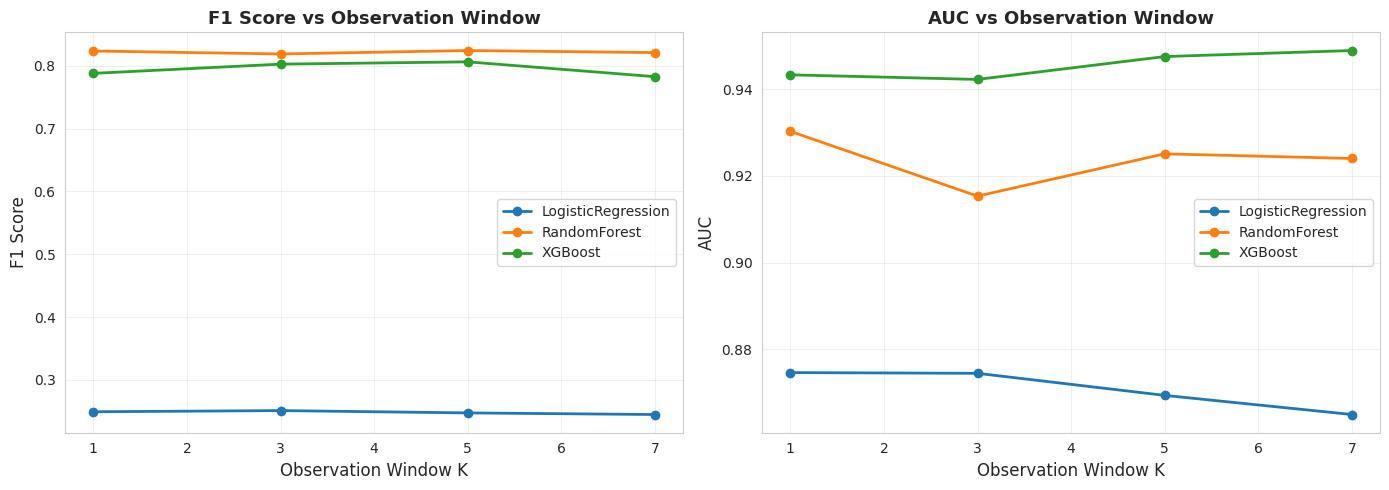

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score
ax = axes[0]
for model_name in models_config.keys():
    f1_scores = [results[model_name][K]['test']['f1'] for K in CONFIG['observation_windows']]
    ax.plot(CONFIG['observation_windows'], f1_scores, marker='o', label=model_name, linewidth=2)

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# AUC
ax = axes[1]
for model_name in models_config.keys():
    auc_scores = [results[model_name][K]['test']['auc'] for K in CONFIG['observation_windows']]
    ax.plot(CONFIG['observation_windows'], auc_scores, marker='o', label=model_name, linewidth=2)

ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [15]:
from pathlib import Path

# Create results directories for each model
RESULTS_DIR_BASE = Path('../../results/baselines')
RESULTS_DIR_BASE.mkdir(parents=True, exist_ok=True)

model_dirs = {
    'LogisticRegression': RESULTS_DIR_BASE / 'logistic_regression',
    'RandomForest': RESULTS_DIR_BASE / 'random_forest',
    'XGBoost': RESULTS_DIR_BASE / 'xgboost'
}

for model_name, model_dir in model_dirs.items():
    model_dir.mkdir(parents=True, exist_ok=True)
    
    # Collect metrics for this model
    all_metrics = []
    for K in CONFIG['observation_windows']:
        for split_name in ['train', 'val', 'test']:
            metrics = results[model_name][K][split_name]
            all_metrics.append({
                'K': K,
                'split': split_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'auc': metrics['auc']
            })
    
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.to_csv(model_dir / 'all_metrics.csv', index=False)
    
    # Save summary statistics (with std=0 for compatibility)
    summary_stats = []
    test_metrics = metrics_df[metrics_df['split'] == 'test']
    for K in CONFIG['observation_windows']:
        k_metrics = test_metrics[test_metrics['K'] == K].iloc[0]
        summary_stats.append({
            'K': K,
            'f1_mean': k_metrics['f1'],
            'f1_std': 0.0,
            'auc_mean': k_metrics['auc'],
            'auc_std': 0.0,
            'precision_mean': k_metrics['precision'],
            'precision_std': 0.0,
            'recall_mean': k_metrics['recall'],
            'recall_std': 0.0,
            'accuracy_mean': k_metrics['accuracy'],
            'accuracy_std': 0.0
        })
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(model_dir / 'summary_statistics.csv', index=False)
    
    print(f"✓ Saved {model_name} results to {model_dir}")

print(f"\n✅ All baseline results saved!")
print(f"Base directory: {RESULTS_DIR_BASE}")

✓ Saved LogisticRegression results to ../../results/baselines/logistic_regression
✓ Saved RandomForest results to ../../results/baselines/random_forest
✓ Saved XGBoost results to ../../results/baselines/xgboost

✅ All baseline results saved!
Base directory: ../../results/baselines
